In [1]:
!pip install imutils
!pip install efficientnet

In [2]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [22]:
from pathlib import Path

# Specify the directory containing the images
img_dir = 'C:\\Users\\prana\\Downloads\\gaussian_filtered_images'

# Convert the directory path to a Path object
image_dir = Path(img_dir)

# Use the Path object's glob method to search for all .png files in the directory and its subdirectories
filepaths = list(image_dir.glob('**/*.png'))

# Initialize a list to store labels
labels = []

# Iterate through the list of file paths
for filepath in filepaths:
    # Extract the label from the file path
    # The label is the name of the parent directory of the image file
    label = filepath.parent.name
    # Append the label to the labels list
    labels.append(label)




In [23]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

df.head(4)
df['Label'].value_counts()

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: Label, dtype: int64

In [24]:
import plotly.express as px

Class_series = pd.Series(df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity',
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()

In [25]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(df['Label'])
df['Label']=labelEncoder.transform(df['Label'])

In [26]:
from sklearn.utils import resample

n_samples = 400
label_counts = df['Label'].value_counts()
dfs_by_label_resampled = {}

# Iterate through each label
for label in range(5):    
    # Check if there are enough samples for resampling
    if label_counts[label] < n_samples:
        # If there are not enough samples, duplicate the existing ones to reach 400
        df_label_resampled = pd.concat([df[df['Label'] == label]] * ((n_samples + label_counts[label] - 1) // label_counts[label]))
        df_label_resampled = df_label_resampled.sample(n_samples, replace=True, random_state=42)
    else:
        # If there are enough samples, resample to get exactly 400
        df_label_resampled = resample(df[df['Label'] == label], n_samples=n_samples, replace=True, random_state=42)
        
            # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

# Concatenate the resampled DataFrames
balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Label'].value_counts()

4    400
0    400
3    400
2    400
1    400
Name: Label, dtype: int64

In [27]:
balanced_df.head()

,Filepath,Label
0,C:\Users\prana\Downloads\gaussian_filtered_ima...,4
1,C:\Users\prana\Downloads\gaussian_filtered_ima...,0
2,C:\Users\prana\Downloads\gaussian_filtered_ima...,3
3,C:\Users\prana\Downloads\gaussian_filtered_ima...,2
4,C:\Users\prana\Downloads\gaussian_filtered_ima...,3


In [28]:
import plotly.express as px

Class_series = pd.Series(balanced_df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity',
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()

In [29]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd

# Set the directory where your images are stored
#directory = 'C:/Users/prana/Downloads/gaussian_filtered_images'  # Update this path as needed

# Create a pattern to access all PNG files in the directory
#pattern = os.path.join(directory, '**', '*.png')

# Use glob to get all file paths matching the pattern
#image_paths = glob(pattern)

# Create a DataFrame named 'balanced_df' with image paths
#balanced_df = pd.DataFrame(image_paths, columns=['Filepath'])

# Define the target image size
size = (224, 224)

# Define the function to load and resize images
def load_image_and_resize(filepath):
    img = Image.open(filepath)
    img = img.resize(size)  # Resize image to 224x224
    img = np.asarray(img)  # Convert image to numpy array
    return img

# Map the function to the 'Filepath' column in 'balanced_df' to create the 'image' column
balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))



In [30]:
balanced_df.shape

(2000, 3)

In [31]:
directory = 'C:/Users/prana/Downloads/gaussian_filtered_images'

# Create a pattern to access all PNG files in the directory
pattern = os.path.join(directory, '*', '*.png')

# Use glob to get all file paths matching the pattern
image_paths = glob(pattern)

size = (224, 224)


def load_image_and_resize(filepath):
        img = Image.open(filepath)
        img = img.resize(size)
        img = np.asarray(img)
        return img

balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))

In [33]:
balanced_df.shape

(2000, 3)

In [34]:
from keras.utils import to_categorical
x=np.asarray(balanced_df['image'].to_list())
x=x/255
y=balanced_df['Label']
y=to_categorical(y,num_classes=5)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42,shuffle=True)

In [35]:
x

array([[[[0.48627451, 0.50196078, 0.50196078],
         [0.50196078, 0.48627451, 0.48627451],
         [0.50196078, 0.50196078, 0.50196078],
         ...,
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.48627451, 0.48627451]],

        [[0.50196078, 0.51764706, 0.51764706],
         [0.51764706, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         ...,
         [0.50196078, 0.50196078, 0.50196078],
         [0.51764706, 0.50196078, 0.50196078],
         [0.52941176, 0.51372549, 0.51372549]],

        [[0.49803922, 0.49019608, 0.49803922],
         [0.50588235, 0.49019608, 0.49019608],
         [0.50196078, 0.48627451, 0.48627451],
         ...,
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.48627451, 0.50196078],
         [0.49803922, 0.50980392, 0.50980392]],

        ...,

        [[0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078]

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from keras.callbacks import EarlyStopping


es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, patience=10, verbose=1, mode='auto')
vgg = DenseNet121(input_shape=(224,224,3),weights='imagenet',include_top=False)
vgg.trainable = False
x = Flatten()(vgg.output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.4)(x)

prediction = Dense(5,activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train ,
                    y_train ,
                    epochs=70 ,
                    batch_size=8,
                    validation_data=(x_test , y_test) ,
                    callbacks=es
                    )



Epoch 1/70


200/200 [==============================] - 91s 420ms/step - loss: 1.4884 - accuracy: 0.4712 - val_loss: 1.0648 - val_accuracy: 0.5775
Epoch 2/70
200/200 [==============================] - 79s 393ms/step - loss: 1.0429 - accuracy: 0.5544 - val_loss: 0.9869 - val_accuracy: 0.6000
Epoch 3/70
200/200 [==============================] - 79s 396ms/step - loss: 0.9414 - accuracy: 0.6019 - val_loss: 0.9087 - val_accuracy: 0.6525
Epoch 4/70
200/200 [==============================] - 78s 390ms/step - loss: 0.8387 - accuracy: 0.6612 - val_loss: 0.9113 - val_accuracy: 0.6225
Epoch 5/70
200/200 [==============================] - 79s 394ms/step - loss: 0.7921 - accuracy: 0.6875 - val_loss: 0.8597 - val_accuracy: 0.6475
Epoch 6/70
200/200 [==============================] - 303s 2s/step - loss: 0.6708 - accuracy: 0.7294 - val_loss: 0.7520 - val_accuracy: 0.7225
Epoch 7/70
200/200 [==============================] - 78s 388ms/step - loss: 0.6471 - accuracy: 0.7538 - val_loss: 0.7666 - val_

In [37]:
loss, accuracy = model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 14s 927ms/step - loss: 0.6680 - accuracy: 0.8200
Test Loss: 0.6679523587226868
Test Accuracy: 0.8199999928474426


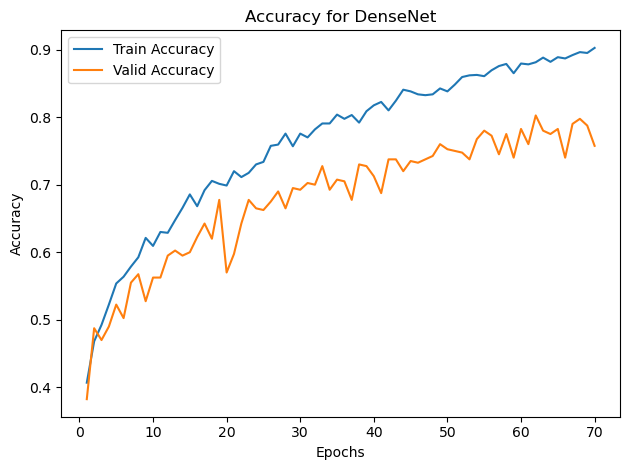

In [42]:
import matplotlib.pyplot as plt


tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = [i+1 for i in range(len(tr_acc))]



plt.plot(epochs, tr_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Valid Accuracy')
plt.title('Accuracy for DenseNet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=10, verbose=1, mode='auto')
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg.trainable = False

x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=70,
                    batch_size=8,
                    validation_data=(x_test, y_test),
                    callbacks=[es])


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/70
200/200 [==============================] - 108s 538ms/step - loss: 1.3929 - accuracy: 0.4069 - val_loss: 1.2556 - val_accuracy: 0.3825
Epoch 2/70
200/200 [==============================] - 106s 532ms/step - loss: 1.2265 - accuracy: 0.4681 - val_loss: 1.1974 - val_accuracy: 0.4875
Epoch 3/70
200/200 [==============================] - 106s 532ms/step - loss: 1.1611 - accuracy: 0.4925 - val_loss: 1.1840 - val_accuracy: 0.4700
Epoch 4/70
200/200 [==============================] - 106s 532ms/step - loss: 1.1278 - accuracy: 0.5225 - val_loss: 1.1441 - val_accuracy: 0.4900
Epoch 5/70
200/200 [==============================] - 105s 527ms/step - loss: 1.0878 - accuracy: 0.5537 - val_loss: 1.0966 - val_accuracy: 0.5225
Epoch 6/70
200/200 [==============================] - 105s 527ms/step - loss: 1.0499 - accuracy: 0.5638 - val_loss: 1.1228 - val_accuracy: 0.5025
Epoch 7/70
200/200 [==============================] - 107s 

In [40]:
loss, accuracy = model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 [==============================] - 19s 1s/step - loss: 0.7819 - accuracy: 0.7575
Test Loss: 0.781867265701294
Test Accuracy: 0.7574999928474426


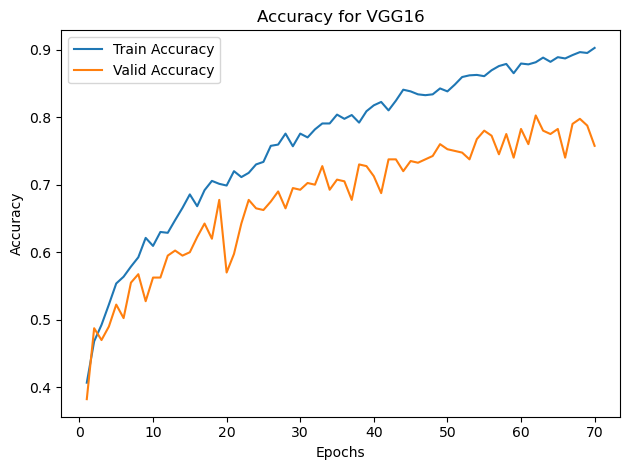

In [43]:
import matplotlib.pyplot as plt


tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = [i+1 for i in range(len(tr_acc))]



plt.plot(epochs, tr_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Valid Accuracy')
plt.title('Accuracy for VGG16')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import seaborn as sns
from PIL import Image, ImageOps, ImageDraw
import os
# data augmentation
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.patches as patches
%matplotlib inline
# ml and deep learning libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load dataset
data = pd.read_csv('C:/Users/sreej/Desktop/project/train.csv')

image_folder = 'C:/Users/sreej/Desktop/project/images/'

def image_path(id_code):
    return image_folder + id_code + '.png'

data['image_path'] = data['id_code'].apply(image_path)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

y_train = train_df['diagnosis']
x_train = train_df.drop('diagnosis', axis=1)

y_test = test_df['diagnosis']
x_test = test_df.drop('diagnosis', axis=1)

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

batch_size = 32


def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  
    image = tf.image.resize(image, [224, 224])
    # Normalize to [0, 1] range
    image /= 255.0  
   
    return image, label

def load_dataset(df, is_training=True):
    images = df['image_path'].values
    labels = pd.get_dummies(df['diagnosis']).values
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.map(preprocess_image).shuffle(buffer_size=1000).repeat()
    else:
        dataset = dataset.map(preprocess_image)
    return dataset.batch(32)

train_dataset = load_dataset(train_df)
test_dataset = load_dataset(test_df, is_training=False)

total_test_points = len(test_dataset)

# baseline CNN model
model = Sequential([
    Input(shape=(224, 224, 1)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_df['diagnosis'].unique()), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weights_dict = dict(enumerate(class_weights))

# fit the model
history = model.fit(
    train_dataset,
    steps_per_epoch=90, 
    epochs=15,
    validation_data=test_dataset,
    validation_steps = total_test_points // batch_size, 
    class_weight = class_weights_dict
)

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential

test_images, test_labels = next(iter(test_dataset.unbatch().batch(len(test_df))))
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by rows for recall
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Replace with your actual class names

# Confusion Matrix
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

# Precision Plot
cm_normalized_by_columns = cm.astype('float') / cm.sum(axis=0)
plot_confusion_matrix(cm_normalized_by_columns, class_names, title='Precision', normalize=True)

# Recall Plot
plot_confusion_matrix(cm, class_names, title='Recall', normalize=True)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1_scores = f1_score(true_classes, predicted_classes, average=None)

# classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

def plot_metric_scores(scores, classes, metric_name, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(np.diag(scores).reshape(-1, len(classes)), annot=True, fmt='.2f', cmap=cmap, 
                cbar=False, xticklabels=classes, yticklabels=[metric_name])
    plt.title(f'{metric_name} for each class')
    plt.xlabel('Class')
    plt.yticks(rotation=0)  # Keep the metric name horizontal for readability
    plt.show()

# F1 Scores Plot
plot_metric_scores(f1_scores, class_names, 'F1 Score')

